In [1]:
import os
import sys
# FIXME: figure out how to avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from vines.geometry.geometry import shape
from vines.fields.plane_wave import PlaneWave
from vines.operators.acoustic_operators import volume_potential, volume_potential_cylindrical
from vines.precondition.threeD import circulant_embed_fftw
from vines.operators.acoustic_matvecs import mvp_volume_potential, mvp_vec_fftw
from scipy.sparse.linalg import LinearOperator, gmres
from matplotlib import pyplot as plt
from vines.geometry.geometry import generatedomain2d, generatedomain
from vines.fields.transducers import bowl_transducer, normalise_power
import time
import matplotlib
from matplotlib import pyplot as plt
import itertools

In [2]:
def my_round(n):
    delta = n - np.floor(n)
    if delta < 0.5:
        part = np.floor(n)
    else:
        part = np.ceil(n)
    return part

'''                        Define medium parameters                         '''
# * speed of sound (c)
# * medium density (\rho)
# * the attenuation power law info (\alpha_0, \eta)
# * nonlinearity parameter (\beta)
material = 'water'
c = 1480.0
rho = 1000.0
alpha0 = 0.2
eta = 2
beta = 3.5e0

In [3]:
def attenuation(f, alpha0, eta):
    'Attenuation function'
    alpha = alpha0 * (f * 1e-6)**eta
    alpha = alpha / 8.686 
    return alpha


'''                      Define transducer parameters                       '''
# * operating/fundamental frequency f1
# * radius of curvature, focal length (roc)
# * inner diameter (inner_D)
# * outer diameter (outer_D)
# * total acoustic power (power)
f1 = 1.1e6
transducername = 'H131_linear'
roc = 0.035
inner_D = 0.0
outer_D = 0.033
power = 100

# f1 = 1.1e6
# transducername = 'H101_linear'
# roc = 0.0632
# inner_D = 0.0
# outer_D = 0.064
# power = 100

In [4]:
focus = [roc, 0., 0.]
# FIXME: need source pressure as input

# How many harmonics to compute
n_harm = 2

# Mesh resolution (number of voxels per fundamental wavelength)
nPerLam = 4

# Compute useful quantities: wavelength (lam), wavenumber (k0),
# angular frequency (omega)
lam = c / f1
k1 = 2 * np.pi * f1 / c + 1j * attenuation(f1, alpha0, eta)
omega = 2 * np.pi * f1

# Create voxel mesh
dx = lam / (2 * nPerLam)

In [5]:
x_start = roc - 0.99 * np.sqrt(roc**2 - (outer_D/2)**2)
x_end = roc + 0.01
wx = x_end - x_start
wy = outer_D * 1
wz = wy

start_to_focus = roc - x_start

start = time.time()
r, L, M, N = generatedomain(dx, wx, wy, wz)
# Adjust r
r[:, :, :, 0] = r[:, :, :, 0] - r[0, 0, 0, 0] + x_start
end = time.time()
print('Mesh generation time:', end-start)
points = r.reshape(L*M*N, 3, order='F')

print('Number of voxels = ', L*M*N)

Mesh generation time: 4.736502647399902
Number of voxels =  9258256


In [6]:
start = time.time()
n_elements = 2**12
x, y, z, p = bowl_transducer(k1, roc, focus, outer_D / 2, n_elements,
                             inner_D / 2, points.T, 'x')
end = time.time()
print('Incident field evaluation time (s):', end-start)
dist_from_focus = np.sqrt((points[:, 0]-focus[0])**2 + points[:, 1]**2 +
                           points[:,2]**2)
idx_near = np.abs(dist_from_focus - roc) < 5e-4
p[idx_near] = 0.0

# Normalise incident field to achieve desired total acoutic power
p0 = normalise_power(power, rho, c, outer_D/2, k1, roc,
                     focus, n_elements, inner_D/2)

p *= p0

P = np.zeros((n_harm, L, M, N), dtype=np.complex128)
# P[0] = p.reshape(L, M, N, order='F')
P = []
P.append(p.reshape(L, M, N, order='F'))

Incident field evaluation time (s): 341.2096788883209


Text(0, 0.5, 'Pressure (MPa)')

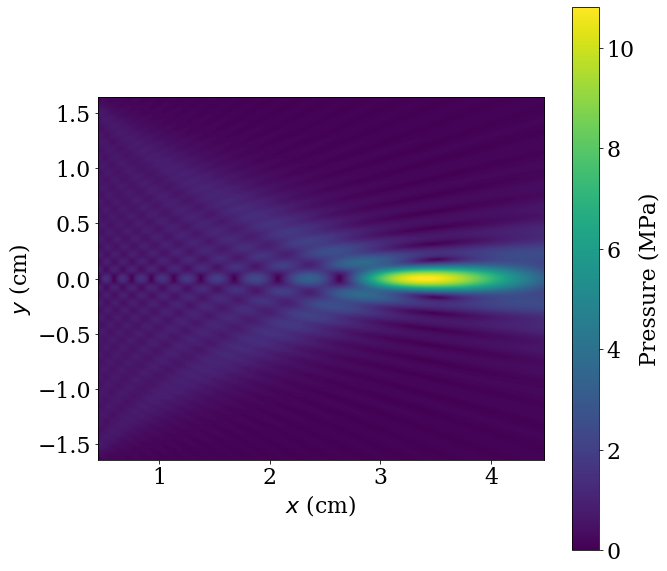

In [8]:
# Set up interpolation function for P[0]
from scipy.interpolate import RegularGridInterpolator, Rbf
X = r[:, 0, 0, 0]
Y = r[0, :, 0, 1]
Z = r[0, 0, :, 2]
interp_func_p1 = RegularGridInterpolator((X, Y, Z), P[0],
                                                    method='linear')

# Store interpolation functions in a list
interp_funs = []
interp_funs.append(interp_func_p1)

# Create a pretty plot of the first harmonic in the domain
matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
xmin, xmax = r[0, 0, 0, 0] * 100, r[-1, 0, 0, 0] * 100
ymin, ymax = r[0, 0, 0, 1] * 100, r[0, -1, 0, 1] * 100
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(np.abs(P[0][:, :, np.int(np.floor(N/2))].T / 1e6),
           extent=[xmin, xmax, ymin, ymax],
           cmap=plt.cm.get_cmap('viridis'), interpolation='spline16')
plt.xlabel(r'$x$ (cm)')
plt.ylabel(r'$y$ (cm)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pressure (MPa)')

In [9]:
# Create empty list into which we put the axis coordinates for different meshes
X_AXIS = []
ny_centre = np.int(my_round(M/2)-1)
nz_centre = np.int(my_round(N/2)-1)
X_AXIS.append(r[:, ny_centre, nz_centre, 0])

# Store on axis fields in a list
P_AXIS = []
P_AXIS.append(P[0][:, ny_centre, nz_centre])

# Power of two function. Used when subdividing mesh
def is_power_of_two(n):
    return (n != 0) and (n & (n-1) == 0)

In [11]:
'''      Compute the next harmonics by evaluating the volume potential      '''
for i_harm in range(1, n_harm):
    f2 = (i_harm + 1) * f1
    k2 = 2 * np.pi * f2 / c + 1j * attenuation(f2, alpha0, eta)

    if i_harm!=1:
        # Generate the new mesh and perform the interpolation of previous harmonics
        # onto it
        # For the meantime, let's just half the mesh size in all dimensions
        lam2 = 2*np.pi / np.real(k2)

        ''' Testing '''
        dx2 = lam2 / nPerLam
        # x_start = roc - start_to_focus / i_harm
        x_start2= roc - 0.99 * np.sqrt(roc**2 - (outer_D/2)**2) * 2 / (i_harm + 1)
        x_end2 = roc + 0.01
        wx2 = x_end2 - x_start2
        wy2 = outer_D * 2 / (i_harm + 1)
        wz2 = wy2
        # x_start = roc - start_to_focus * i_harm / (i_harm + 1)
        # x_end = roc + 0.01 - dx
        # wx2 = x_end - x_start
        # wy2 = wy /2
        start = time.time()
        r2, L2, M2, N2 = generatedomain(dx2, wx2, wy2, wz2)
        end = time.time()
        print('Mesh generation for next harmonic = ', end-start)
        print('No. DOF for next harmonic = ', L2 * M2 * N2)
        # Adjust r2 so that the far ends of r-dx and r2 coincide
        r2[:, :, :, 0] = r2[:, :, :, 0] - r2[-1, 0, 0, 0] + r[-1, 0, 0, 0] + \
                        -dx/2 - dx2/2
        
        points2 = r2.reshape(L2*M2*N2, 3, order='F')

        r = r2
        L, M, N = L2, M2, N2
        X = r[:, 0, 0, 0]
        Y = r[0, :, 0, 1]
        Z = r[0, 0, :, 2]
        dx, wx, wy, wz = dx2, wx2, wy2, wz2
        ''' end testing '''
        # If the harmonic is even number, we divide mesh size by 2
        # from IPython import embed; embed()
        # if (i_harm % 2) == 0:  # then even harmonic
        # if is_power_of_two(i_harm): # if harmonic is just after power of 2
        # # if True:
        #     dx2 = dx/2
        #     # wx2 = wx / 2

        #     x_start2 = roc - start_to_focus / i_harm
        #     x_end2 = roc + 0.01
        #     wx2 = x_end2 - x_start2
            
        #     wy2 = wy / 2
        #     wz2 = wy2
        #     start = time.time()
        #     r2, L2, M2, N2 = generatedomain(dx2, wx2, wy2, wz2)
        #     end = time.time()
        #     print('Mesh generation for next harmonic = ', end-start)
        #     print('No. DOF for next harmonic = ', L2 * M2 * N2)
        #     # Adjust r2 so that the far ends of r-dx and r2 coincide
        #     r2[:, :, :, 0] = r2[:, :, :, 0] - r2[-1, 0, 0, 0] + r[-1, 0, 0, 0] + \
        #                     -dx/2 - dx2/2
            
        #     points2 = r2.reshape(L2*M2*N2, 3, order='F')

        #     r = r2
        #     L, M, N = L2, M2, N2
        #     X = r[:, 0, 0, 0]
        #     Y = r[0, :, 0, 1]
        #     Z = r[0, 0, :, 2]
        #     dx, wx, wy, wz = dx2, wx2, wy2, wz2
    
        # # Interpolate P1 and P2 onto finer grid
        # start = time.time()
        # # p1_interp = interp_func_p1(points2)
        # p1_interp = interp_funs[0](points2)
        # P1_interp = p1_interp.reshape(L2, M2, N2, order='F')
        # p2_interp = interp_func_p2(points2)
        # P2_interp = p2_interp.reshape(L2, M2, N2, order='F')
        # end = time.time()
        # print('Interpolation time = ', end-start)
        # Assemble volume potential Toeplitz operator perform circulant embedding
    start = time.time()
    toep_op = volume_potential(k2, r)

    circ_op = circulant_embed_fftw(toep_op, L, M, N)
    end = time.time()
    print('Operator assembly and its circulant embedding:', end-start)

    # Create vector for matrix-vector product
    if i_harm == 1:
        # Second harmonic
        xIn = -2 * beta * omega**2 / (rho * c**4) * P[0] * P[0]
    elif i_harm == 2:
        # Third harmonic
        # Interpolate P1 and P2 onto finer grid
        start = time.time()
        p1_interp = interp_funs[0](points2)
        P1_interp = p1_interp.reshape(L2, M2, N2, order='F')
        p2_interp = interp_funs[1](points2)
        P2_interp = p2_interp.reshape(L2, M2, N2, order='F')
        end = time.time()
        print('Interpolation time = ', end-start)
        xIn = -9 * beta * omega**2 / (rho * c**4) * P1_interp * P2_interp
    elif i_harm == 3:
        # Fourth harmonic
        start = time.time()
        p1_interp = interp_funs[0](points2)
        P1 = p1_interp.reshape(L2, M2, N2, order='F')
        p2_interp = interp_funs[1](points2)
        P2 = p2_interp.reshape(L2, M2, N2, order='F')
        p3_interp = interp_funs[2](points2)
        P3 = p3_interp.reshape(L2, M2, N2, order='F')
        end = time.time()
        print('Interpolation time = ', end-start)
        xIn = -8 * beta * omega**2 / (rho * c**4) * \
            (P2 * P2 + 2 * P1 * P3)
    elif i_harm == 4:
        # Fifth harmonic
        start = time.time()
        p1_interp = interp_funs[0](points2)
        P1 = p1_interp.reshape(L2, M2, N2, order='F')
        p2_interp = interp_funs[1](points2)
        P2 = p2_interp.reshape(L2, M2, N2, order='F')
        p3_interp = interp_funs[2](points2)
        P3 = p3_interp.reshape(L2, M2, N2, order='F')
        p4_interp = interp_funs[3](points2)
        P4 = p4_interp.reshape(L2, M2, N2, order='F')
        end = time.time()
        print('Interpolation time = ', end-start)
        xIn = -25 * beta * omega**2 / (rho * c**4) * \
            (P1 * P4 + P2 * P3)
    elif i_harm == 5:
        # Sixth harmonic
        xIn = -18 * beta * omega**2 / (rho * c**4) * \
            (2 * P[0] * P[4] + 2 * P[1] * P[3] + P[2]**2)
    elif i_harm == 6:
        # Seventh harmonic
        xIn = -49 * beta * omega**2 / (rho * c**4) * \
            (P[0] * P[5] + P[1] * P[4] + P[2] * P[3])

    xInVec = xIn.reshape((L*M*N, 1), order='F')
    idx = np.ones((L, M, N), dtype=bool)

    def mvp(x):
        'Matrix-vector product operator'
        return mvp_volume_potential(x, circ_op, idx, Mr)

    # Voxel permittivities
    Mr = np.ones((L, M, N), dtype=np.complex128)

    # Perform matrix-vector product
    start = time.time()
    
    P.append(mvp(xInVec).reshape(L, M, N, order='F'))
    end = time.time()
    print('MVP time = ', end - start)

    # Set up grid interpolation function for this new harmonic
    # FIXME: rename
    interp_func_p2 = RegularGridInterpolator((X, Y, Z), P[i_harm],
                                                    method='linear')

    # Append interpolation function to the list
    interp_funs.append(interp_func_p2)

    # from IPython import embed; embed()

    # Find x-axis coordinates and append to list
    # ny_centre = np.int(np.round(M/2)-1)
    # nz_centre = np.int(np.round(N/2)-1)
    ny_centre = np.int(my_round(M/2)-1)
    nz_centre = np.int(my_round(N/2)-1)
    x_line = (r[:, ny_centre, nz_centre, 0])
    X_AXIS.append(x_line)

    # Append on axis field to list
    P_AXIS.append(P[i_harm][:, ny_centre, nz_centre])

Operator assembly and its circulant embedding: 24.32247805595398
MVP time =  20.878660202026367


Text(0, 0.5, 'Pressure (MPa)')

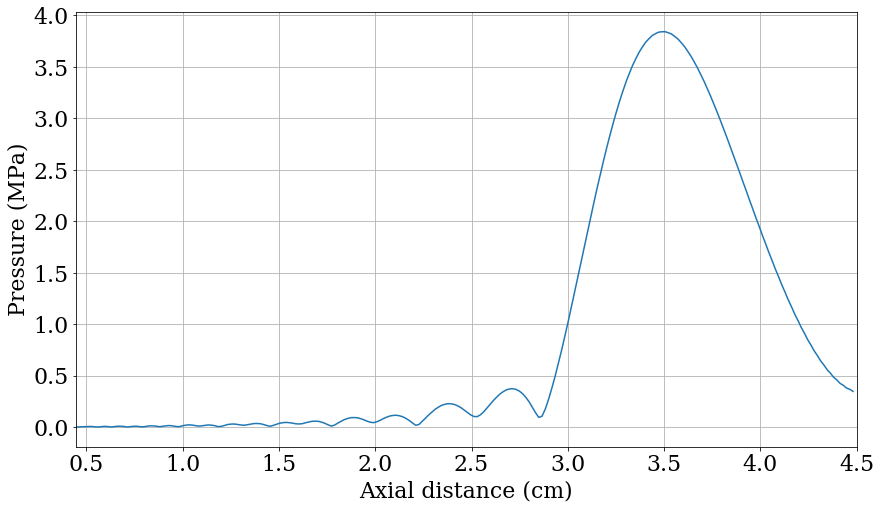

In [15]:
fig = plt.figure(figsize=(14, 8))
ax = fig.gca()
for i_harm in range(1,n_harm):
    # plt.plot(x_line, np.abs(P[i_harm][:, ny_centre, nz_centre])/1e6)
    plt.plot(X_AXIS[i_harm]*100, np.abs(P_AXIS[i_harm])/1e6)
plt.grid(True)
plt.xlim([x_start*100, x_end*100])
# plt.ylim([0, np.max(np.abs(P_AXIS[0]))/1e6])
plt.xlabel(r'Axial distance (cm)')
plt.ylabel(r'Pressure (MPa)')